In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
#From keras
import keras
from keras.models import load_model
# from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers,regularizers
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger

# From ssd_keras
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
import ssd_encoder_decoder.ssd_output_decoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
from SSD_loss import SSDLoss
from eval_utils.average_precision_evaluator import Evaluator
from importlib import reload
#import cv2
from data_augment import LabelEncoder
from detector_help import process_y,post_process,prior_box
import detection_nets,classification_nets
import tensorflow as tf
from matplotlib import pyplot as plt
from drawing import *

%matplotlib inline

Using TensorFlow backend.


### Set model config

In [3]:
input_H = 300
input_W = 300
input_C = 3
input_shape = (input_H, input_W, input_C)
model_name = "ssdlite_mn2"
root_path = "/home/cai/dataset/VOCdevkit"
aspect_ratios = [[2,3],
                 [2,3],
                 [2,3],
                 [2,3],
                 [2],
                 [2]]

mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
num_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
variances = [0.1, 0.1, 0.2, 0.2]
scale = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
# scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
# scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
# scales = scales_pascal
# # aspect_ratios = [[1.0, 2.0, 0.5],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5],
# #                  [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
# two_boxes_for_ar1 = True
# steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
# offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
# clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
#variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
# normalize_coords = True

### Build model 

In [14]:
reload(detection_nets)
K.clear_session()
build_model = detection_nets.build_ssdlite_300
#Don`t tune learning rate here because we will use a lr scheduler in callbacks
#Orignal paper used SGD but according to the author of ssd_keras, use adam is better 
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)
model = build_model(
                    aspect_ratios=aspect_ratios,
                    num_classes=num_classes)
# for layer in model.layers[:120]:
#     layer.trainable = False
model.summary()                       #Comment this line if you don`t want to show summary every time you build your model
for layer in model.layers:
    layer.W_regularizer = regularizers.l2(0.00005)    

model = detection_nets.preprocess(input_shape,model,mean_color,swap_channels)
# model = multi_gpu_model(model,gpus=2) #Comment it if don`t use multi_gpu 
model.compile(adam,
              loss=ssd_loss.loss,
              metrics = [ssd_loss.class_loss,ssd_loss.loc_loss]
              )
print(model_name,'has been built ')

Tensor("block_12_expand_1/convolution:0", shape=(?, 19, 19, 576), dtype=float32)
Tensor("out_relu_1/Relu6:0", shape=(?, 10, 10, 1280), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 5, 5, 512), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 3, 3, 256), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 3, 3, 256), dtype=float32)
Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 1, 1, 128), dtype=float32)
[[19, 19], [10, 10], [5, 5], [3, 3], [3, 3], [1, 1]]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_3[

ssdlite_mn2 has been built 


### Load previously trained models 

In [4]:
K.clear_session() # Clear previous models from memory.

model_path = "saved_weights/ssdlite_mn2_pascal_07+12_epoch-92_loss-2.2986_val_loss-2.6116.h5"
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)
# #Load old model
# model.compile(adam,
#               loss=ssd_loss.loss,
#               metrics = [ssd_loss.class_loss,ssd_loss.loc_loss]
#               )
# model = multi_gpu_model(model,gpus=2) #Comment it if don`t use multi_gpu 
model = load_model(model_path,custom_objects={'loss': ssd_loss.loss,'class_loss':ssd_loss.class_loss,'loc_loss':ssd_loss.loc_loss})
#model = load_model(model_path,custom_objects={'loss': ssd_loss.loss,'class loss': ssd_loss.class_loss, 'loc loss': ssd_loss.loc_loss})
print("load model from",model_path)   

load model from saved_weights/ssdlite_mn2_pascal_07+12_epoch-92_loss-2.2986_val_loss-2.6116.h5


### Define featue map as predictor size 

In [5]:
feature_map_300 = [19,10,5,3,3,1]
feature_map_224 = [7,7,4,4,2,1]

In [6]:
#Define class_names
class_names = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

force_create_dataset = False #Force data generator to load dataset from source

## Load Dataset

In [7]:
root_path = '/home/cai/dataset/VOCdevkit'
trainset_hdf5_path = 'dataset_pascal_voc_07+12_trainval.h5'
valset_hdf5_path = 'dataset_pascal_voc_07_test.h5'

# The directories that contain the images.
VOC_2007_images_dir      = root_path + '/VOC2007/JPEGImages/'
VOC_2012_images_dir      = root_path + '/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = root_path + '/VOC2007/Annotations/'
VOC_2012_annotations_dir      = root_path + '/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = root_path + '/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = root_path + '/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = root_path + '/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = root_path + '/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = root_path + '/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = root_path + '/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = root_path + '/VOC2007/ImageSets/Main/test.txt'

if os.path.isfile(trainset_hdf5_path) and os.path.isfile(valset_hdf5_path) and not force_create_dataset:
    #Load dataset from created hdf5_dataset
    train_dataset = DataGenerator(hdf5_dataset_path = trainset_hdf5_path)
    val_dataset = DataGenerator(hdf5_dataset_path = valset_hdf5_path)
else:
    train_dataset = DataGenerator()
    val_dataset = DataGenerator()
    
    train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                         VOC_2012_images_dir],
                            image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                                 VOC_2012_trainval_image_set_filename],
                            annotations_dirs=[VOC_2007_annotations_dir,
                                              VOC_2012_annotations_dir],
                            classes=class_names,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                          image_set_filenames=[VOC_2007_test_image_set_filename],
                          annotations_dirs=[VOC_2007_annotations_dir],
                          classes=class_names,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)
    train_dataset.create_hdf5_dataset(file_path=trainset_hdf5_path,
                                      resize=False,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=valset_hdf5_path,
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 6643.64it/s]


## Data Augment 

In [8]:
import detector_help
reload(detector_help)
from detector_help import *
import data_augment
reload(data_augment)
from data_augment import *

batch_size = 32
ssd_data_augmentation = SSDDataAugmentation(img_height=input_H,
                                            img_width=input_W,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=input_H, width=input_W)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
priors = prior_box(feature_map_300,aspect_ratios,scale = scale)
label_encoder = LabelEncoder(num_classes,priors,variances,input_H,input_W)

# ssd_input_encoder = SSDInputEncoder(img_height=input_H,
#                                     img_width=input_W,
#                                     n_classes=num_classes,
#                                     predictor_sizes=feature_map,
#                                     scales=scales,
#                                     aspect_ratios_per_layer=aspect_ratios,
#                                     two_boxes_for_ar1=two_boxes_for_ar1,
#                                     steps=steps,
#                                     offsets=offsets,
#                                     clip_boxes=clip_boxes,
#                                     variances=variances,
#                                     matching_type='multi',
#                                     pos_iou_threshold=0.5,
#                                     neg_iou_limit=0.5,
#                                     normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=label_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=label_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()
print("Number of priors:\t{:>6}".format(len(priors)))
print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of priors:	  3010
Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## Define callback function

In [19]:
#1. Set file path
weights_folder = 'saved_weights/'

if not os.path.isdir(weights_folder):
    os.mkdir(weights_folder)

checkpoint_filepath = weights_folder + model_name + '_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
log_filepath = model_name + '_pascal_07+12_training_log.csv' 
#2. Define lr schedule function
def lr_schedule(epoch):
    if epoch < 40:
        return 0.0005
    elif epoch < 80:
        return 0.0001
    else:
        return 1e-5
    
#3. ## Define callbacks
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=log_filepath,
                           separator=',',
                           append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]
# callbacks = [csv_logger,learning_rate_scheduler]

## Draw a batch of images(optional)

In [ ]:
train_flow_origin = train_dataset.generate(batch_size = 4,
                                           transformations=[], 
                                           label_encoder = label_encoder,
                                           returns = ['original_images','original_labels'])
images,labels = next(train_flow_origin)
for img,label in zip(images, labels):
    draw_detection(img,label,class_names)           

### Debug encoder-decoder and data augment

In [ ]:
import detector_help
reload(detector_help)
import ssd_encoder_decoder.ssd_output_decoder
reload(ssd_encoder_decoder.ssd_output_decoder)
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
train_flow_encode = train_dataset.generate(batch_size = 8,
                                           transformations= [convert_to_3_channels,
                                                      resize], 
                                           label_encoder = label_encoder,
                                           shuffle = False,
                                           returns=["processed_images","processed_labels","encoded_labels"])

images,enc_labels,proc_labels = next(train_flow_encode) 
enc_labels_custom = detector_help.post_process(enc_labels,
                                               priors,
                                               variances,
                                               num_classes,
                                               input_H,input_W, 
                                               score_thresh = 0.06,   
                                               iou_thresh = 0.45,
                                               top_k = 1000) # Use top_k as 1000 because all gt labels`s conf are 1
enc_labels_default = decode_detections(enc_labels,
                  priors,
                  np.array(variances),
                  img_height = input_H,
                  img_width = input_W,
                  confidence_thresh = 0.06,
                  iou_threshold = 0.45)

# for img,enc_default_label,enc_custom_label,proc_label in zip(images,enc_labels_default,enc_labels_custom,proc_labels):
#     print(enc_custom_label)
#     draw_detection(img, proc_label, class_names, color = 'green')
#     #plt.title('Default decoder')
#     #draw_detection(img, enc_default_label, class_names, color = 'red')
#    # plt.title('Custom decoder')
#     draw_detection(img, enc_custom_label, class_names, color = 'purple')

In [1]:

import time
base_img = np.zeros((300,300,3))
plt.imshow(base_img)
current_axis = plt.gca()
print(len(priors))
for k,box in enumerate(priors[:100]):
#     plt.imshow(base_img)
#     current_axis = plt.gca()
#     if k%100 == 0:
#         base_img = np.zeros((300,300,3))
#         #plt.imshow(base_img)
#         current_axis = plt.gca()
    xmid,ymid,w,h = box[-4:]
    xmid *= 300
    ymid *= 300
    w *= 300
    h *= 300
    if k < 1000:
        color = 'red'
    else:
        color = 'green'
    current_axis.add_patch(plt.Rectangle((xmid - w/2, ymid - h/2), w,h, color=color, fill=False, linewidth=2)) 

NameError: name 'np' is not defined

### Set training params

In [20]:
#If load weights from files,initial_epoch need to be set to the next epoch to be trained.
initial_epoch = 0
final_epochs = 100
steps_per_epoch = 1000
plot = True

## Train the model

In [ ]:
print('model name' ,model_name , \
       '\nstart fitting.. ' , 
       'inital epoch:', initial_epoch,
       'final epoch:', final_epochs,
       'epoch step:', steps_per_epoch,
       'plot_history:' ,plot, \
       '\ntrainset size:',  train_dataset.get_dataset_size(), ' batch_size', batch_size )     

validation_steps =  val_dataset.get_dataset_size() // batch_size
history = model.fit_generator(train_generator,
                              use_multiprocessing = True, 
                              steps_per_epoch = steps_per_epoch, 
                              validation_data = val_generator,
                              validation_steps = validation_steps, 
                              epochs = final_epochs,
                              callbacks = callbacks,
                              initial_epoch = initial_epoch)

if plot:
    plot_history(history)
    plt.savefig('./rfbmn2_300_pascal07+12_train.jpg')



model name ssdlite_mn2 
start fitting..  inital epoch: 0 final epoch: 100 epoch step: 1000 plot_history: True 
trainset size: 16551  batch_size 32
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005.
1000/1000 [==============================] - 1450s 1s/step - loss: 6.9705 - class_loss: 5.4636 - loc_loss: 1.5069 - val_loss: 5.3012 - val_class_loss: 3.8112 - val_loc_loss: 1.4900

Epoch 00001: val_loss improved from inf to 5.30116, saving model to saved_weights/ssdlite_mn2_pascal_07+12_epoch-01_loss-6.9718_val_loss-5.3012.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005.
 118/1000 [==>...........................] - ETA: 15:52 - loss: 4.7342 - class_loss: 3.4526 - loc_loss: 1.2815

### Evaluate

In [73]:
import eval_utils.average_precision_evaluator
reload(eval_utils.average_precision_evaluator)
from eval_utils.average_precision_evaluator import Evaluator

In [74]:
test_dataset = DataGenerator()
test_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=class_names,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=False,
                      ret=False)
print('Test size', test_dataset.get_dataset_size())

Processing image set 'test.txt': 100%|██████████| 4952/4952 [00:14<00:00, 351.65it/s]
Test size 4952


In [75]:
evaluator = Evaluator(model=model,
                      n_classes=num_classes,
                      data_generator=test_dataset,
                      model_mode='training')

results = evaluator(img_height=input_H,
                    img_width=input_W,
                    batch_size=batch_size,
                    priors = priors,
                    variances = variances,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4952

Producing predictions batch-wise: 100%|██████████| 155/155 [02:36<00:00,  1.01s/it]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 9676/9676 [00:00<00:00, 11213.07it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 5907/5907 [00:00<00:00, 11440.79it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 35406/35406 [00:02<00:00, 13662.76it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 26638/26638 [00:01<00:00, 15604.08it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 51141/51141 [00:03<00:00, 16089.25it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 5798/5798 [00:00<00:00, 6290.00it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 49189/49189 [00:04<00:00, 10133.98it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 5416/5416 [00:00<00:00, 9772.15it/s]
Matching pre

In [77]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(class_names[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.711
bicycle       AP    0.77
bird          AP    0.651
boat          AP    0.574
bottle        AP    0.278
bus           AP    0.788
car           AP    0.747
cat           AP    0.836
chair         AP    0.468
cow           AP    0.702
diningtable   AP    0.698
dog           AP    0.746
horse         AP    0.799
motorbike     AP    0.787
person        AP    0.67
pottedplant   AP    0.427
sheep         AP    0.672
sofa          AP    0.726
train         AP    0.8
tvmonitor     AP    0.69

              mAP   0.677


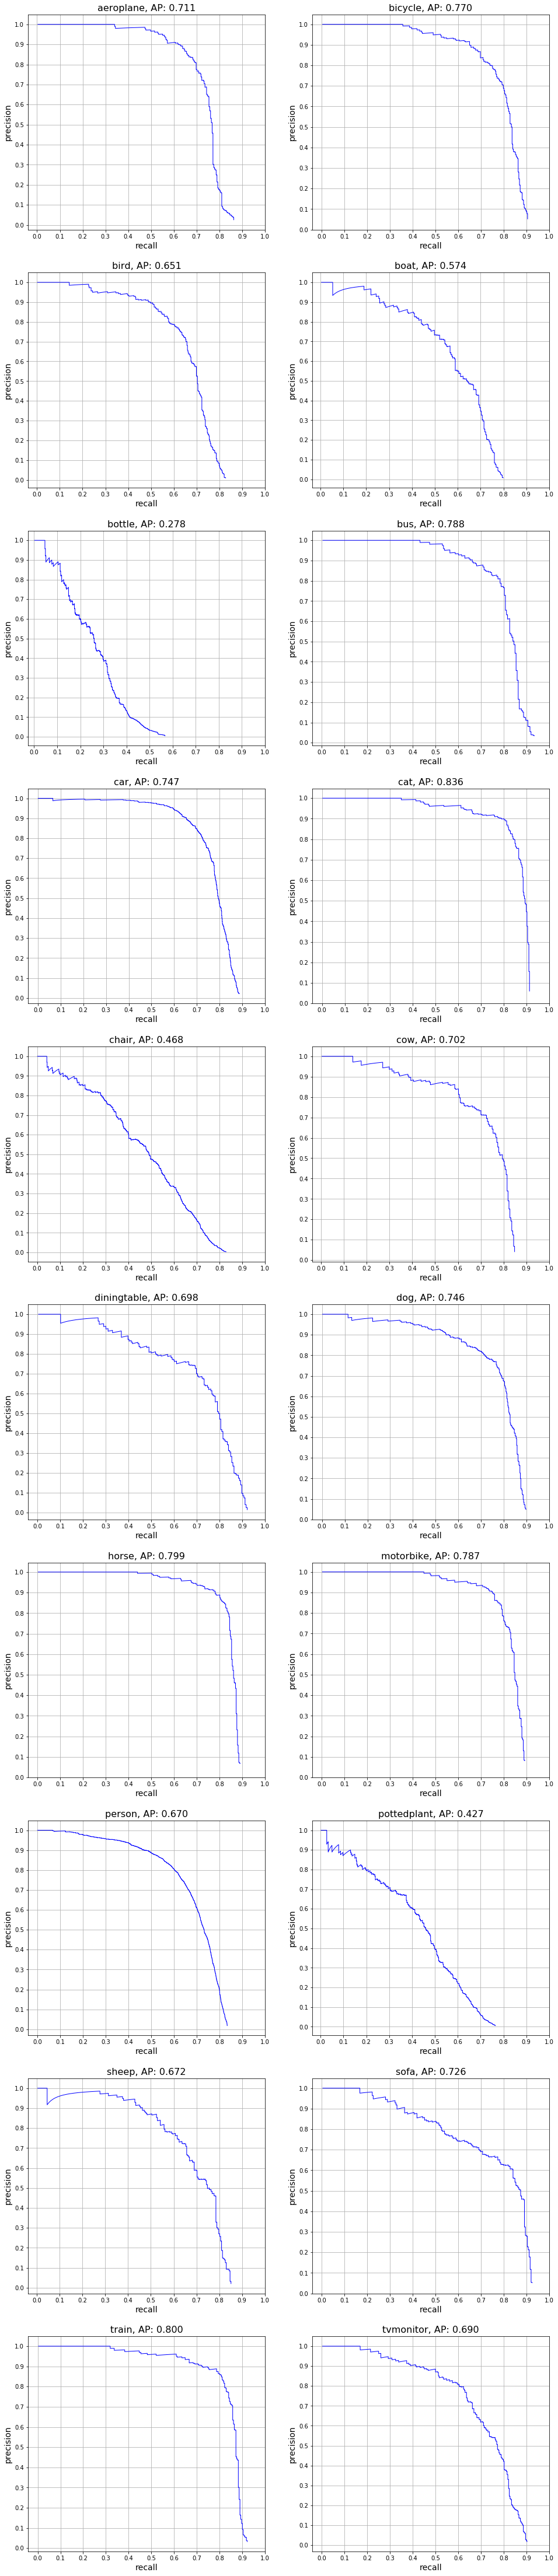

In [78]:
m = max((num_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > num_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(class_names[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

### Predict

In [9]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [70]:

# Generate batch_items
batch_images, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

#print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# 3: Make predictions.
y_pred = model.predict(batch_images)


Ground truth boxes:

[[ 15 232  67 320 239]
 [ 15 171  62 239 240]
 [ 15 101  41 178 240]
 [ 15  51  61 116 240]
 [ 15   2  41  73 240]
 [ 15 267  46 320 166]
 [ 15 209  52 222  95]
 [ 15 221  50 231  96]
 [ 15 229  52 242  98]]


In [71]:
# 4: Decode labels
reload(detector_help)
y_pred_decoded = decode_detections(y_pred,
                  priors,variances,
                  img_height = input_H,
                  img_width = input_W,
                  confidence_thresh = 0.5,
                  iou_threshold = 0.45)
# y_pred_decoded = detector_help.post_process(y_pred, 
#                                             priors,
#                                             num_classes,
#                                             input_H, 
#                                             input_W,
#                                             score_thresh = 0.5,
#                                             iou_thresh = 0.4)
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     0.98  -1.    42.    68.   245.  ]
 [ 15.     0.93  58.    43.   119.   243.  ]
 [ 15.     0.89 237.    59.   320.   239.  ]]


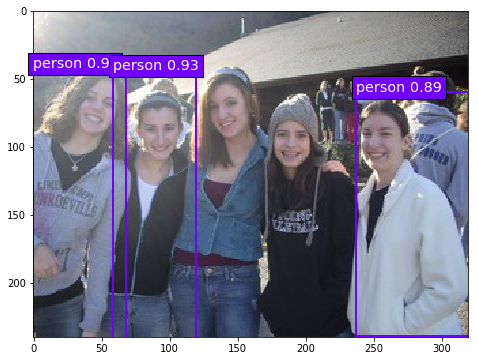

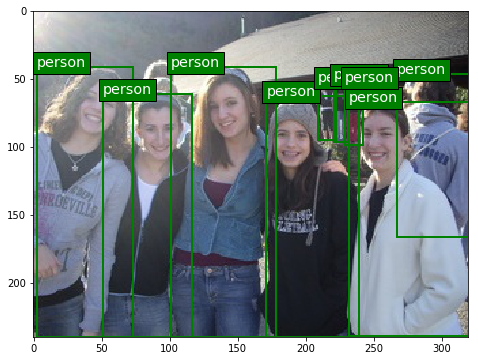

In [72]:
# 5: Draw 
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
draw_detection(batch_original_images[i],y_pred_decoded_inv[i],class_names,
               show = True, draw_score = True,use_cm = True,color = colors, size = 'medium')
draw_detection(batch_original_images[i],batch_original_labels[i],class_names, size = 'medium')


### Image Demo

In [ ]:
img_file = "data/dog3.jpg"
img = cv2.imread(img_file)
img = cv2.resize(img,(224,224))
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))
y_pred = post_process(y_pred,priors,num_classes,input_H,input_W)
print(y_pred)
draw_detection(img,y_pred[0],class_names)

### Video detection demo

In [ ]:
video_file = "data/cat_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    y_pred [-4:] *= [*size,*size]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        print(y_pred)
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')